## Step 3: Detect places with amber mining

In this notebook I'll show example how to use model trained in previous steps to detect interesting satellite images. 

See also [Step 1](step1.ipynb) and [Step 2](step2.ipynb). 

In [ ]:
from __future__ import print_function
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from scipy import misc

from PIL import Image
from skimage.measure import regionprops

import sys
import os

# uncomment line below if you use TensorFlow with GPU support, ie CUDA libraries etc
# os.environ["CUDA_VISIBLE_DEVICES"]="0" # to allocate only one TensorFLow device

import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions


In [2]:
#  load classifier (XGBoost) which we've created in previous steps
_clf = joblib.load('./versions/xgb_model.pkl')

# uncomment to load production model used in our project
# _clf = joblib.load('./versions/xgb_model_v003.pkl')



# load rsnet model (takes some time)
resnet = ResNet50(weights='imagenet', include_top=False)


In [3]:
# create segments from image @name
def slic_segments(name):
    img = img_as_float(io.imread(name))
    return slic(img, n_segments=30, compactness=35, sigma=1)

# prepare superpixel aka segment before classification (crop and scale that segment)
def prepare_segment(segment_info, parent_image_object, target_size=(224, 224)):
    width_height_tuple = (target_size[1], target_size[0])
    y0, x0, y1, x1 = segment_info.bbox
    segment_size = (y1 - y0, x1 - x0)
    
    cropped = parent_image_object.crop((x0, y0, x1, y1))
        
    if segment_size != width_height_tuple:
        resample = Image.NEAREST
        cropped = cropped.resize(width_height_tuple, resample)
        
    return cropped


# extract features for each segment/superpixel from image, return nparray with features for each segments from @img_name
def features_from_tile(img_name, resnet, batch_size = 64):

    segments = [] 
    # get geometry info about each segment
    segments_info = regionprops(slic_segments(img_name))      
    image_object = Image.open(img_name)
    
    n = len(segments_info)
    img_array = np.zeros((n, 224, 224, 3))
    
    for i, s in enumerate(segments_info):
        img = prepare_segment(s, image_object )
        img = image.img_to_array(img)
        img = preprocess_input(img)
        img_array[i] = img
    
        
    X = resnet.predict(img_array, batch_size=batch_size, verbose=0)
    X = X.reshape((n, 2048))
    return X            

# split to segments, get features, classify segment, return lables for each segment        
def search_in_tile(img_name, classifier, resnet, occurences_treshold = 0):
    
    features = features_from_tile(img_name, resnet)
    Y_pred = classifier.predict(features)
    labels = Y_pred.tolist()
    
    if labels.count("positive") > occurences_treshold:
        print("amber detected!")
    return labels

#### Time to apply our classifier and search for amber mining on images! 

In [10]:
# image without amber mining
img_name = "./datasets/example/negative3.png"
labels = search_in_tile(img_name, _clf, resnet) # all labels should be "negative"

In [7]:
# image with amber mining
img_name = "./datasets/example/positive3.png"
labels = search_in_tile(img_name, _clf, resnet)


amber detected!


#### Now lets check visually  - which segments on image detected as "positive", ie with amber mining?

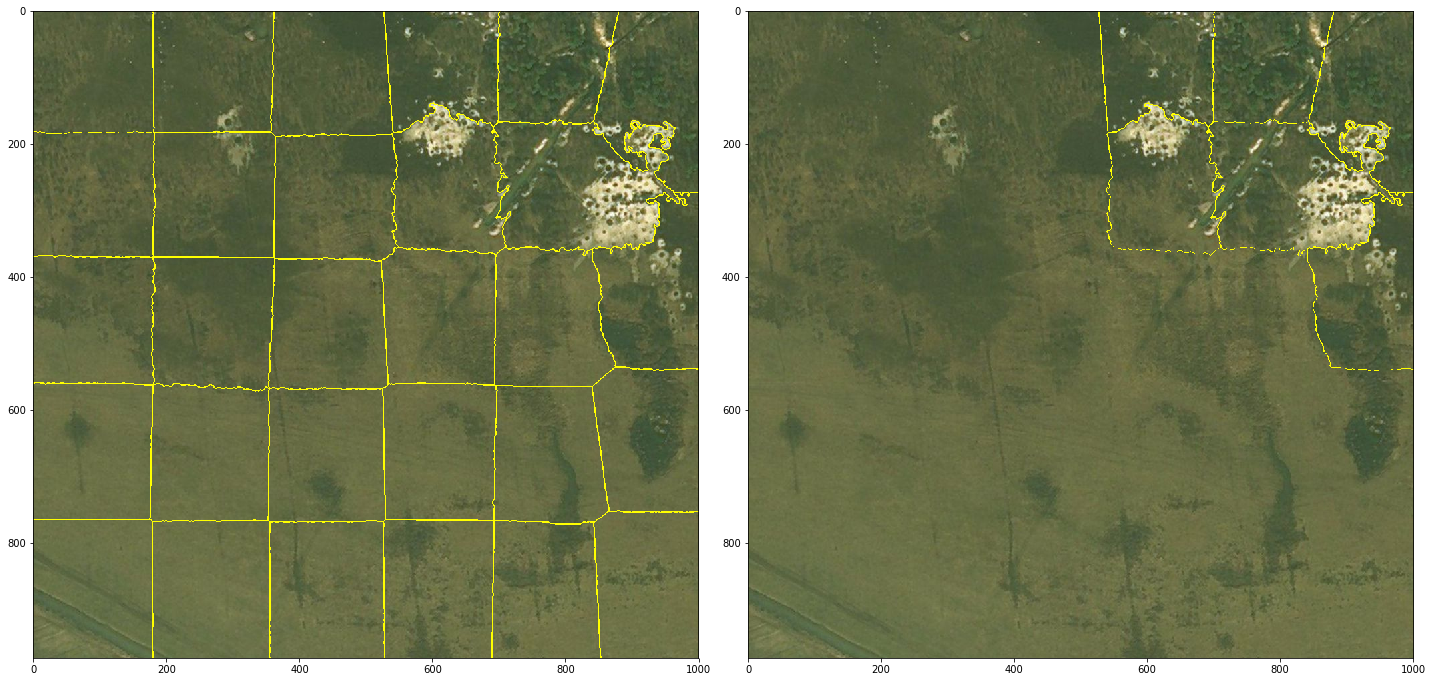

In [8]:
img = io.imread(img_name) # image as numpy array
original_image = Image.fromarray(img.astype('uint8'), 'RGB')  # same image as PIL object
img = img_as_float(img) # convert to float, to use for segmentation purposes


segments_slic = slic(img, n_segments=30, compactness=35, sigma=1) # split image to segments
marked_img_all = mark_boundaries(img, segments_slic) # image with all segments and boundaries

# find label values for each segments without amber
negative_labels = [i+1 for i,l in enumerate(labels) if l == "negative"] 
# segment_slic is image mask, with values for each pixel from segment #1 turned into 1, from segment #2 - to 2, etc,
# so above in negative_labels we collected all numbers for pixel values for "negative" segments 

# Here we filter out from our mask all pixels with this values for "negative" segments
segments_slic[np.isin(segments_slic, negative_labels)] = 0 

marked_img_positive = mark_boundaries(img, segments_slic) # now, new image has only boundaries for positive segments

# Show image with all segments on the left, show image with amber mining on the right
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(marked_img_all)
ax1.imshow(marked_img_positive)
fig.tight_layout()
plt.show()



#### Such a great joy! Our method works, we can find footprints of amber mining on satellite images. 

So we used this method to search satellite images for the area of ~70,000 square km.

Please, read our [project about amber mining in English](http://texty.org.ua/d/2018/amber_eng).

The article has interactive map for all places of illegal amber mining, found by method described in this code 